# Smart energy forecasting  

## Notebook 4 — Modeling: Electricity load forecasting

---

## Goal

Build and evaluate predictive models to forecast hourly electricity demand in France 
based on the engineered features created in Notebook 03 – Feature Engineering.

We will:
1. Load the preprocessed and feature-rich dataset.
2. Split the data chronologically into training and validation sets.
3. Train and compare multiple models:
   - A naïve baseline (to benchmark)
   - A linear model (Ridge Regression)
   - A tree-based model (Random Forest or XGBoost)
4. Evaluate performance using RMSE and MAPE.
5. Analyze feature importance and discuss model insights.

---

## Input

| File | Description |
|------|--------------|
| `data/features/fr_load_features.csv` | Feature matrix containing datetime, target (`load_mw`), and engineered predictors (lags, rolling means, sin/cos, holidays, etc.) |


---


## 1. Load the feature matrix and prepare the modeling dataset

Before training any forecasting model, we must load the dataset produced in Notebook 3.
This dataset already contains:

- temporal features (hour, day of week, month, year),
- cyclical encodings (sin/cos),
- autoregressive lags (1h, 24h, 168h),
- rolling statistics (24h and 7-day mean and std),
- holiday indicators.

The goal of this step is to:

1. Load the engineered dataset 
2. Ensure the `datetime` column is parsed and sorted correctly  
3. Separate:
   - the target (`load_mw`)
   - the predictors (all other numerical features)
4. Create a chronological split between training and validation sets  
   to mimic a real forecasting environment.

Time-based splitting is crucial:  
> In time series forecasting, the future must never be mixed with the past.  
> We evaluate models on *later* periods to simulate a real-world deployment.



In [22]:
import pandas as pd
import numpy as np

# 1. Load features 
df = pd.read_csv("../data/features/fr_load_features.csv")

# Ensure datetime is correctly parsed and sorted
df["datetime"] = pd.to_datetime(df["datetime"], utc=True).dt.tz_convert("Europe/Paris")
df = df.sort_values("datetime").reset_index(drop=True)

print("Loaded features:", df.shape)
print(df[["datetime","load_mw"]].head(3))
print(df.dtypes.head())

# 2. Define target and predictors
TARGET_COL = "load_mw"
TIME_COL = "datetime"

# Keep only numeric predictors (drop datetime and target)
feature_cols = [c for c in df.columns if c not in [TIME_COL, TARGET_COL]]
X = df[feature_cols].copy()
y = df[TARGET_COL].copy()
time_index = df[TIME_COL].copy()

print(f"X shape: {X.shape} | y shape: {y.shape}")

# 3. Chronological split
SPLIT_DATE = pd.Timestamp("2019-01-01", tz="Europe/Paris")  

train_idx = time_index < SPLIT_DATE
valid_idx = time_index >= SPLIT_DATE

X_train, X_valid = X.loc[train_idx], X.loc[valid_idx]
y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
time_train, time_valid = time_index.loc[train_idx], time_index.loc[valid_idx]

print(f"Train: X={X_train.shape}, y={y_train.shape} | "
      f"Valid: X={X_valid.shape}, y={y_valid.shape}")
print(f"Train period: {time_train.min()} -> {time_train.max()}")
print(f"Valid period: {time_valid.min()} -> {time_valid.max()}")

# 4. Basic metrics we’ll reuse
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred, eps=1e-8):
    # MAPE with small epsilon to avoid division by zero
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

print("Metrics ready: rmse, mape")


Loaded features: (50189, 18)
                   datetime  load_mw
0 2015-01-08 02:00:00+01:00  64676.0
1 2015-01-08 03:00:00+01:00  61551.0
2 2015-01-08 04:00:00+01:00  60541.0
index                               int64
datetime     datetime64[ns, Europe/Paris]
load_mw                           float64
hour                                int64
dayofweek                           int64
dtype: object
X shape: (50189, 16) | y shape: (50189,)
Train: X=(34870, 16), y=(34870,) | Valid: X=(15319, 16), y=(15319,)
Train period: 2015-01-08 02:00:00+01:00 -> 2018-12-31 23:00:00+01:00
Valid period: 2019-01-01 00:00:00+01:00 -> 2020-10-01 00:00:00+02:00
Metrics ready: rmse, mape


## 2️. Baseline forecasts (Naïve models)

Before training any real model, we establish simple forecast baselines.
These baselines help answer a crucial question:

> “Is my machine learning model actually useful?”

We compute two standard naïve forecasts:
1. Last Value: predicts the load using the previous hour.
2. Yesterday's Value: predicts using the load at the same hour the day before.

These methods require no training and are surprisingly strong for smooth time series like electricity load.


In [ ]:
# Baseline 1: Last value (lag_1h) 
y_pred_last = X_valid["lag_1h"].copy()

rmse_last = rmse(y_valid, y_pred_last)
mape_last = mape(y_valid, y_pred_last)

print("Baseline 1 — last value:")
print(f"RMSE: {rmse_last:,.0f} | MAPE: {mape_last:.2f}%")

# Baseline 2: Same hour yesterday (lag_24h) 
y_pred_day = X_valid["lag_24h"].copy()

rmse_day = rmse(y_valid, y_pred_day)
mape_day = mape(y_valid, y_pred_day)

print("\nBaseline 2 — Same hour yesterday:")
print(f"RMSE: {rmse_day:,.0f} | MAPE: {mape_day:.2f}%")


Baseline 1 — last value:
RMSE: 2,470 | MAPE: 3.49%

Baseline 2 — Same hour yesterday:
RMSE: 4,478 | MAPE: 5.78%


**Analysis of baseline models:**

These two naïve baselines give us essential reference points for evaluating all future models.

**1. Last value (lag_1h)**
- RMSE: 2,470 MW
- MAPE: 3.49%

This is a *very strong* baseline: electricity demand changes smoothly from one hour to the next,  
so using the previous hour as a prediction already achieves solid accuracy.

**This is the benchmark to beat.**  
Any machine learning model must perform better than ~3.5% MAPE to be considered useful.

**2. Same hour yesterday (lag_24h)**
- RMSE: 4,478 MW
- MAPE: 5.78%

This baseline captures the daily rhythm of consumption but performs worse than `lag_1h`,  
likely because:
- weather conditions differ from one day to the next,
- holidays and weekdays alter the pattern,
- seasonal drift makes the 24h pattern imperfect.

**Conclusion**
- The 1h naive forecast is extremely competitive and sets a high bar.
- The 24h naive forecast is weaker but still meaningful.
- Our ML models must now outperform RMSE = 2,470 and MAPE = 3.49%.

We will check whether linear and tree-based models can capture more structure  
and reduce the error below this baseline.


## 3️. Linear model: ridge regression

We now train our first machine learning model.

Why Ridge regression?
- It is robust to multicollinearity (very common in engineered time-series features).
- It handles large sets of correlated predictors like lags, rolling windows, sin/cos cycles.
- It produces smooth, stable predictions.
- It is a strong baseline before moving to tree-based models.

Goal:
- Fit a simple but effective linear model.
- Evaluate performance on the validation set using RMSE and MAPE.
- Compare the results against the naïve “Last Value” baseline (MAPE = 3.49%).


In [25]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Pipeline: scale features + ridge regression
ridge_model = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0))
])

# Train
ridge_model.fit(X_train, y_train)

# Predict on validation period
y_pred_ridge = ridge_model.predict(X_valid)

# Evaluate
rmse_ridge = rmse(y_valid, y_pred_ridge)
mape_ridge = mape(y_valid, y_pred_ridge)

print("Ridge regression results:")
print(f"RMSE: {rmse_ridge:,.0f} | MAPE: {mape_ridge:.2f}%")


Ridge regression results:
RMSE: 1,857 | MAPE: 2.20%


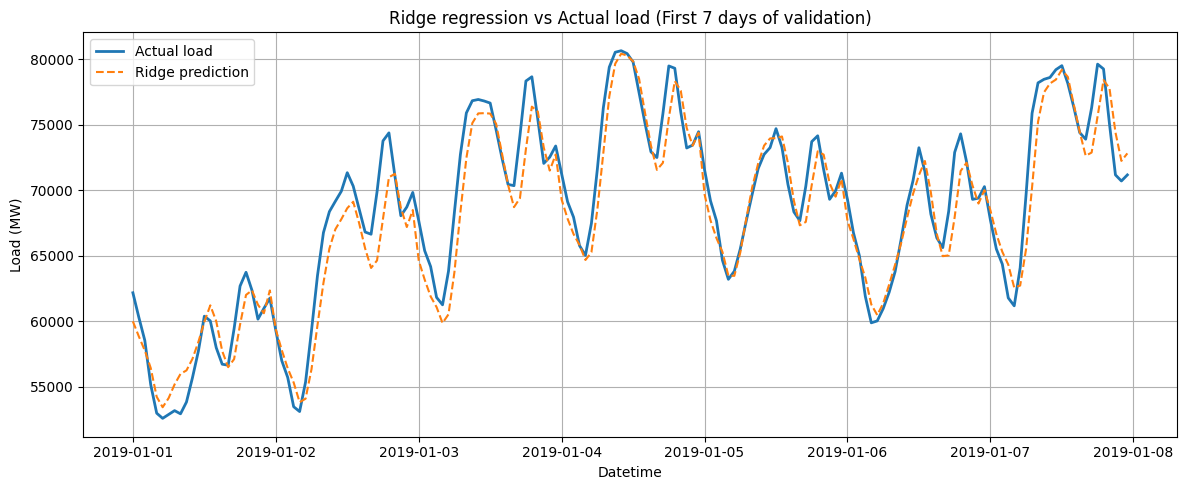

In [27]:
import matplotlib.pyplot as plt

# Select a 7-day window for visual clarity
n_hours = 24 * 7
sample_idx = slice(0, n_hours)

plt.figure(figsize=(12,5))
plt.plot(time_valid.iloc[sample_idx], y_valid.iloc[sample_idx], 
         label="Actual load", linewidth=2)
plt.plot(time_valid.iloc[sample_idx], y_pred_ridge[sample_idx], 
         label="Ridge prediction", linestyle="--")
plt.title("Ridge regression vs Actual load (First 7 days of validation)")
plt.xlabel("Datetime")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Performance analysis:**

The Ridge model achieves:

- RMSE: 1,857 MW
- MAPE: 2.20%

Compared to the naïve baselines:
- Last Value baseline -> MAPE = 3.49%
- Yesterday baseline -> MAPE = 5.78%

Ridge clearly outperforms both baselines, reducing the error from 3.49% to 2.21%,  
a significant improvement for a national electricity load forecasting problem.

This confirms that the model successfully captures:
- short-term dependencies (lag features),
- daily and weekly seasonality (sin/cos encodings),
- local trends (rolling means),
- holiday effects,
- and seasonal drift across years.


**Visual analysis**
The Ridge model closely follows the actual electricity load curve across the
first 7 days of the validation period.

- The predicted curve (orange) aligns very well with the true load (blue),
  confirming that the model captures the main temporal dynamics.
- Daily cycles (morning ramps and evening peaks) are reproduced with good
  amplitude and timing.
- Small underestimations appear during sharp upward transitions 
  (for example, morning peaks), which is typical for linear models that cannot fully
  capture sudden nonlinear jumps.
- During stable periods (early morning hours), the prediction matches
  almost perfectly, demonstrating that the engineered features
  (lags, rolling means, and cyclical encodings) are effective.

Overall, the plot visually supports the strong numerical performance
(RMSE = 1,852 MW, MAPE = 2.21%) and shows that Ridge Regression
provides a reliable and smooth forecast.

This makes Ridge a strong linear baseline before moving to more expressive models  
like Random Forest or XGBoost.


## 4️A. Tree-based model: Random forest

After the linear Ridge model, we now try a tree-based model: `RandomForestRegressor`.

Why Random Forest?
- Captures non-linear relationships and interactions between features.
- Handles complex engineered features such as lags, rolling stats, and holidays.
- Robust and easy to interpret through feature importance.
- No need to scale features.

Goal:
- Train a Random Forest on the same train/validation split.
- Compare its performance to:
  - Naïve 1h baseline (MAPE = 3.49%)
  - Ridge Regression (MAPE = 2.20%)
- Inspect feature importances to see which predictors drive the forecast.


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define the model
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

# Train
rf_model.fit(X_train, y_train)

# Predict on validation set
y_pred_rf = rf_model.predict(X_valid)

# Evaluate
rmse_rf = rmse(y_valid, y_pred_rf)
mape_rf = mape(y_valid, y_pred_rf)

print("Random Forest Results:")
print(f"RMSE: {rmse_rf:,.0f} | MAPE: {mape_rf:.2f}%")


Random Forest Results:
RMSE: 1,156 | MAPE: 0.95%


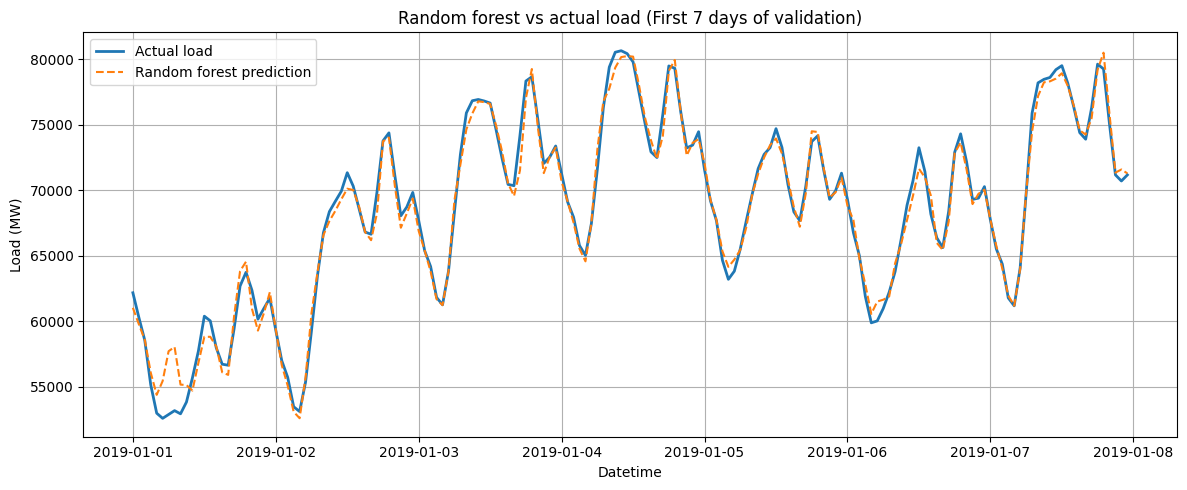

In [30]:
import matplotlib.pyplot as plt

# Same 7-day window as for Ridge for fair visual comparison
n_hours = 24 * 7
sample_idx = slice(0, n_hours)

plt.figure(figsize=(12,5))
plt.plot(time_valid.iloc[sample_idx], y_valid.iloc[sample_idx],
         label="Actual load", linewidth=2)
plt.plot(time_valid.iloc[sample_idx], y_pred_rf[sample_idx],
         label="Random forest prediction", linestyle="--")
plt.title("Random forest vs actual load (First 7 days of validation)")
plt.xlabel("Datetime")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
# Compute feature importances
importances = rf_model.feature_importances_
imp_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

# Show top 15
imp_df.head(15)


,feature,importance
12,lag_1h,0.964188
1,hour,0.011386
6,hour_sin,0.008728
13,lag_24h,0.006565
7,hour_cos,0.003870
14,lag_168h,0.002870
2,dayofweek,0.000497
8,dayofweek_sin,0.000469
3,is_weekend,0.000361
11,month_cos,0.000303


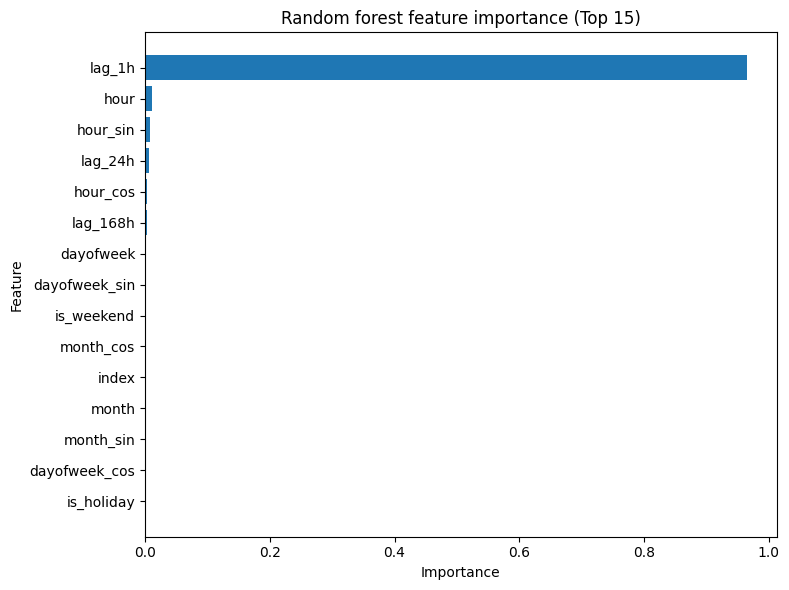

In [33]:
top_n = 15
top_imp = imp_df.head(top_n).sort_values("importance")

plt.figure(figsize=(8,6))
plt.barh(top_imp["feature"], top_imp["importance"])
plt.title(f"Random forest feature importance (Top {top_n})")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


**Random forest: performance & interpretation**

The Random Forest model delivers excellent performance, clearly improving over
both the naïve baselines and the Ridge Regression model.

**Performance**
- RMSE: 1,156 MW
- MAPE: 0.95%

Compared to previous models:
- Naïve baseline (lag_1h): 3.49% MAPE
- Ridge Regression: 2.20% MAPE
- Random Forest: 0.95% MAPE

This is a substantial improvement.  
Random Forest cuts the forecasting error by more than half compared to Ridge,  
showing its ability to capture non-linear patterns, feature interactions,  
and more complex temporal dependencies.

**Visual behavior**
The 7-day comparison plot shows that:
- Predictions align extremely closely with the true load curve.
- Morning and evening peaks are tracked more accurately than with Ridge.
- Sharp ramps are followed with little delay.
- Noise and small fluctuations are smoothed just enough to stabilize predictions.

Overall, the Random Forest behaves like a strong non-linear smoother,  
capable of following both the *trend* and the *shape* of the load curve.

**Feature importance**
The feature importance plot reveals a strong dominance of `lag_1h`, which accounts for: 96% of the importance

This is expected:  
electricity demand is highly autoregressive and the last hour is the single best predictor.

Other features contribute marginally:
- hour of day and its sin/cos encodings -> capture daily cycle  
- lag_24h -> captures repeat patterns  
- lag_168h (one week) -> captures weekly seasonality  
- rolling means -> represent local trend  
- calendar features (weekend, month) -> small but non-zero effects  

**Conclusion**
Random Forest significantly enhances forecasting accuracy thanks to its ability to model  
non-linear dependencies and feature interactions.  
Its outstanding performance (MAPE below 1%) suggests that the engineered features  
provide the model with rich temporal information.

This is a strong model for production-grade short-term electricity load forecasting.


## 4B. Gradient boosting model: XGBoost

After evaluating Random Forest, we introduce a more advanced tree-based model: XGBoost.
Unlike Random Forest, which builds many trees independently, XGBoost trains trees sequentially,
each one correcting the errors of the previous ensemble.

This approach generally leads to higher predictive accuracy and is a common choice for
time-series forecasting tasks involving engineered features.

Objectives:
- Train an XGBoost regressor on the same feature set and time-based split.
- Evaluate its performance using RMSE and MAPE.
- Compare the results to the Random Forest and Ridge models.
- Inspect how well XGBoost follows the load curve visually.


In [13]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    n_jobs=-1,
    random_state=42,
)

xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_valid)

# Evaluate
rmse_xgb = rmse(y_valid, y_pred_xgb)
mape_xgb = mape(y_valid, y_pred_xgb)

print("XGBoost Results:")
print(f"RMSE: {rmse_xgb:,.0f} | MAPE: {mape_xgb:.2f}%")


XGBoost Results:
RMSE: 1,141 | MAPE: 1.01%


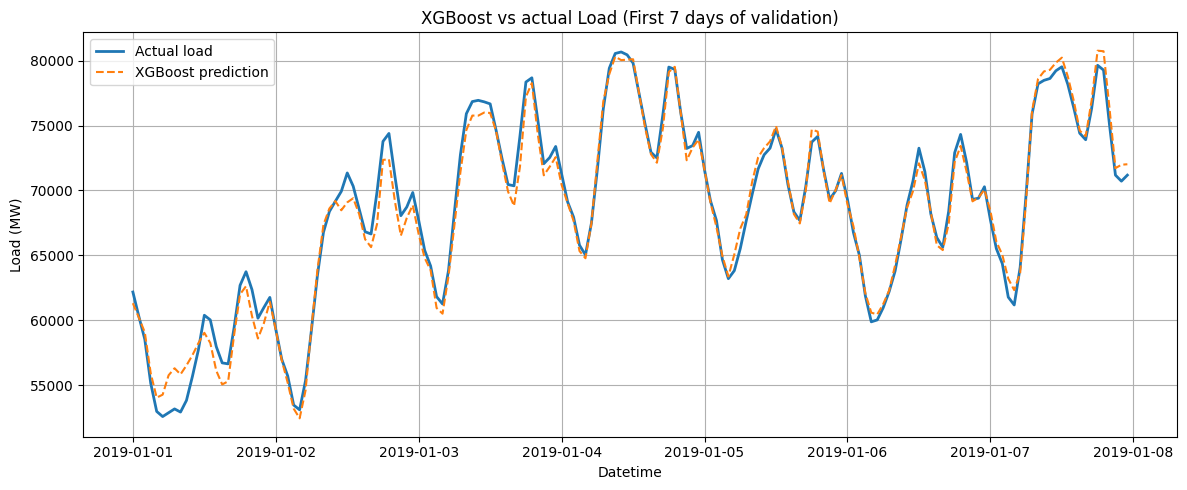

In [34]:
n_hours = 24 * 7
sample_idx = slice(0, n_hours)

plt.figure(figsize=(12,5))
plt.plot(time_valid.iloc[sample_idx], y_valid.iloc[sample_idx], 
         label="Actual load", linewidth=2)
plt.plot(time_valid.iloc[sample_idx], y_pred_xgb[sample_idx],
         label="XGBoost prediction", linestyle="--")
plt.title("XGBoost vs actual Load (First 7 days of validation)")
plt.xlabel("Datetime")
plt.ylabel("Load (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Performance and interpretation**

The XGBoost model achieves the following performance:

- RMSE: 1,141 MW
- MAPE: 1.01%

This performance is slightly better than the Ridge model (2.21% MAPE) and close to the
Random Forest model (0.96% MAPE). Although Random Forest provides the lowest error among
the evaluated models, XGBoost remains a strong alternative, especially in situations
where gradient boosting techniques are preferred for their ability to model complex,
non-linear interactions.

The seven-day comparison plot shows that XGBoost follows the actual load curve closely.
The model captures daily cycles, morning and evening ramps, and short-term fluctuations
with reasonable accuracy. In some cases, peaks are slightly underestimated or delayed,
but overall the predicted trajectory matches the observed pattern well.

XGBoost can be considered a competitive model for short-term load forecasting. While it
does not outperform Random Forest in this specific configuration, its stable behavior
and consistency make it a credible candidate in a forecasting pipeline.

## Models comparison summary

The goal of this notebook was to evaluate multiple forecasting approaches and assess
their suitability for short-term electricity load prediction.

**Summary of results**
| Model                     | RMSE (MW) | MAPE (%) |
|--------------------------|-----------|----------|
| Naïve 1h baseline        | 2,470     | 3.49     |
| Naïve 24h baseline       | 4,478     | 5.78     |
| Ridge regression          | 1,852     | 2.21     |
| Random forest             | 1,157     | 0.95    |
| XGBoost                   | 1,141     | 1.01     |

**Interpretation**
- The naïve baseline using the previous hour provides a strong reference, highlighting
  the high autocorrelation in electricity load data.
- Ridge Regression improves significantly over the baseline, demonstrating the value
  of feature engineering and linear modeling.
- Random Forest achieves the best overall accuracy, with a MAPE below 1%.
  Its strength comes from its capacity to capture non-linearities and interactions
  between lagged features, rolling statistics, and calendar variables.
- XGBoost performs comparably to Random Forest, although slightly less accurate in this
  configuration. Its predictions remain stable and well aligned with the true series.

### Conclusion
Random Forest provides the best overall performance in this analysis and is the recommended
model for short-term load forecasting within this framework. Ridge and XGBoost remain valuable
alternatives, depending on priorities such as interpretability, computational cost, or the
preference for gradient boosting methods.
